Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import time

from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from pyrcn.echo_state_network import ESNClassifier
from pyrcn.linear_model import FastIncrementalRegression, IncrementalRegression
from pyrcn.base import InputToNode, NodeToNode
import matplotlib
from matplotlib import pyplot as plt
#Options
import scipy.stats
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
"""
params = {'image.cmap' : 'RdBu',
          'text.usetex' : True,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
"""

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import librosa
import librosa.display

Print number of files that are included in the dataset

In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

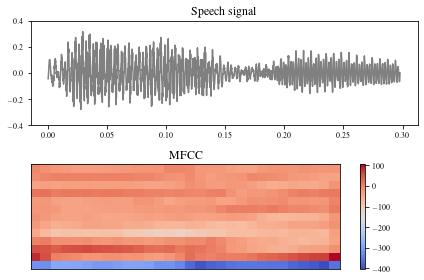

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(2, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [4]:
X_train = []
X_test = []
time_signals_train = []
time_signals_test = []
f_name_train = []
f_name_test = []
y_train = []
y_test = []
print("extracting features...")
with tqdm(total=len(all_files)) as pbar:
    for k, f in enumerate(all_files):
        basename = os.path.basename(f).split('.')[0]
        # Get label (0-9) of recording.
        label = int(basename.split('_')[0])
        idx = int(basename.split('_')[2])
        # Load the audio signal and normalize it.
        x, sr = librosa.core.load(f, sr=None, mono=False)
        # x /= np.max(np.abs(x))
        mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        if idx <= 4:
            f_name_test.append(f)
            time_signals_test.append(x)
            X_test.append(mfcc.T)
            y_test.append(label)
        else:
            f_name_train.append(f)
            time_signals_train.append(x)
            X_train.append(mfcc.T)
            y_train.append(label)
        pbar.update(1)
print("done!")

extracting features...


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:19<00:00, 150.40it/s]


done!


In [5]:
time_signals_train, time_signals_val, _, _ = train_test_split(time_signals_train, y_train, test_size=0.1, random_state=1, stratify=y_train)
f_name_train, f_name_val_val, _, _ = train_test_split(f_name_train, y_train, test_size=0.1, random_state=1, stratify=y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

Validate training and test sizes

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_val), len(y_val), X_val[0].shape, y_val[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2430 2430 (50, 13) 1
270 270 (41, 13) 8
300 300 (30, 13) 0


## Normalize all features using the StandardScaler from scikit-learn.

In [7]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = [scaler.transform(X) for X in X_train]
X_val_scaled = [scaler.transform(X) for X in X_val]
X_test_scaled = [scaler.transform(X) for X in X_test]

Feature visualization

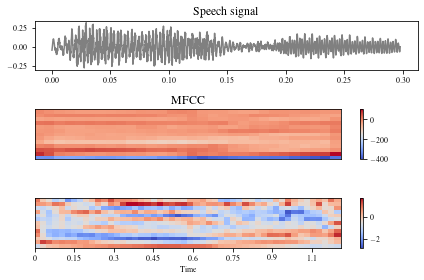

In [8]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(3, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(X_train_scaled[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

Random experiments

In [ ]:
for rs in range(20):
    base_input_to_nodes = InputToNode(hidden_layer_size=100, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0, random_state=rs)
    base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=1.0, leakage=0.1, bias_scaling=0.0, k_rec=10, random_state=10)

    base_esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                             nodes_to_nodes=[('default', base_nodes_to_nodes)],
                             regressor=FastIncrementalRegression(alpha=1e-3), random_state=rs)
    print("Train the ESN model...")
    esn = clone(base_esn)
    for X, y in zip(X_train_scaled + X_val_scaled[:-1], y_train + y_val[:-1]):
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, classes=np.arange(10))
    X = X_val[-1]
    y = np.repeat(y_val[-1], repeats=X.shape[0], axis=0)
    esn.partial_fit(X=X, y=y, update_output_weights=True)
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled + X_val_scaled, y_train + y_val):
        Y_true_train.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        # mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    # print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        # mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    # print("MSE test: %f\n" % (np.mean(mse_test)))


Initialize an Echo State Network

In [ ]:
base_input_to_nodes = InputToNode(hidden_layer_size=100, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0, random_state=10)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=0.0, leakage=1.0, bias_scaling=0.0, k_rec=10, random_state=10)
# base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=1.0, leakage=0.1, bias_scaling=0.0, k_rec=10, random_state=10)

base_esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                         nodes_to_nodes=[('default', base_nodes_to_nodes)],
                         regressor=FastIncrementalRegression(alpha=1e-3), random_state=1)

Clone the base_esn and fit it on the training data

In [ ]:
esn = clone(base_esn)
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled[:-1], y_train + y_val[:-1]):
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, classes=np.arange(10))
        pbar.update(1)
    X = X_val[-1]
    y = np.repeat(y_val[-1], repeats=X.shape[0], axis=0)
    esn.partial_fit(X=X, y=y, update_output_weights=True)
    pbar.update(1)
print("... done!")

Test the model on the training and test set

In [ ]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled, y_train + y_val):
        Y_true_train.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
plt.show()

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
plt.show()

Visualization of time signals from the training set

In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax1 = plt.subplot(111)
im = ax1.imshow(X_train_scaled[361].T,vmin=np.min(X_train_scaled[361]), vmax=np.max(X_train_scaled[361]))

plt.xlim([0,X_train_scaled[361].shape[0]])
plt.ylim([0, X_train_scaled[361].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.grid()

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("top", size="100%", pad=0.7)
cax = divider.append_axes("right", size="3%", pad=0.2)
cb = plt.colorbar( im, ax=ax1, cax=cax )

t = np.arange(len(time_signals_train[361])) / sr
#ax2 = plt.subplot( gs[-1,:] )  # , sharex=ax1
ax2.plot(t, time_signals_train[361], 'dimgrey')
ax2.set_xlim(t[0], t[-1])
ax2.set_ylim(-0.4, 0.4)
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$y(t)$')
ax2.grid(True)

# fig.tight_layout()
width = 3.487
height =3 * width / 1.618
fig.set_size_inches(width, height)
plt.savefig('time_signal_and_features_train.pdf', bbox_inches = 'tight', pad_inches = 0)
# np.savetxt(X=np.vstack((t, time_signals_train[1])).T, fname="time_signal_train.txt", delimiter="\t")

Visualization of features from the training set

In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
im = plt.imshow(X_train_scaled[361].T,vmin=np.min(X_train_scaled[361]), vmax=np.max(X_train_scaled[361]))
plt.xlim([0,X_train_scaled[361].shape[0]])
plt.ylim([0, X_train_scaled[361].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
# plt.colorbar(im)
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)

plt.colorbar(im, cax=cax)
fig.set_size_inches(width, height)
plt.savefig('features_train.pdf', bbox_inches = 'tight', pad_inches = 0)

Visualizations of features from the test set

In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
im = plt.imshow(X_test_scaled[0].T,vmin=np.min(X_test_scaled[0]), vmax=np.max(X_test_scaled[0]))
plt.xlim([0, X_test[0].shape[0]])
plt.ylim([0, X_test[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
# plt.colorbar(im)
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)

plt.colorbar(im, cax=cax)
fig.set_size_inches(width, height)
plt.savefig('features_test.pdf', bbox_inches = 'tight', pad_inches = 0)

Visualization of a reservoir state from the training set

In [ ]:
_ = esn.predict(X=X_train_scaled[361])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.nodes_to_nodes[0][1]._hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.nodes_to_nodes[0][1]._hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
tick_locator = ticker.MaxNLocator(nbins=5)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
plt.savefig('input_scaling_rand_train.pdf', bbox_inches = 'tight', pad_inches = 0)

print(f_name_train[361])

In [ ]:
reservoir_states_0 = []
reservoir_states_1 = []
reservoir_states_2 = []
reservoir_states_3 = []
reservoir_states_4 = []
reservoir_states_5 = []
reservoir_states_6 = []
reservoir_states_7 = []
reservoir_states_8 = []
reservoir_states_9 = []
for X, y, fname in zip(X_train_scaled + X_val_scaled, y_train + y_val, f_name_train + f_name_val_val):
    if "0_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_0.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "1_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_1.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "2_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_2.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "3_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_3.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "4_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_4.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "5_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_5.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "6_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_6.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "7_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_7.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "8_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_8.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "9_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_9.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)

rand_states_training = []
rand_states_training.append(np.var(np.vstack(reservoir_states_0), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_7), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_5), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_6), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_9), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_1), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_3), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_4), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_8), axis=0))
rand_states_training.append(np.var(np.vstack(reservoir_states_2), axis=0))

for k in range(len(rand_states_training)):
    print(np.min(rand_states_training[k]), np.max(rand_states_training[k]))

Visualization of a reservoir state from the test set

In [ ]:
_ = esn.predict(X=X_test_scaled[0])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.nodes_to_nodes[0][1]._hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.nodes_to_nodes[0][1]._hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
plt.savefig('spectral_radius_rand_test.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
plt.hist(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0), bins=10, orientation='horizontal')
rand_states_test = esn.nodes_to_nodes[0][1]._hidden_layer_state
plt.hist(np.var(rand_states_test, axis=0), orientation='horizontal')
np.min(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0)), np.max(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0))

Random experiments

In [ ]:
for rs in range(20):
    kmeans = MiniBatchKMeans(n_clusters=100, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=rs)
    kmeans.fit(X=np.concatenate(X_train_scaled+X_val_scaled))
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    print("Train the ESN model...")
    base_input_to_nodes = InputToNode(hidden_layer_size=100, activation='identity', k_in=10, input_scaling=0.8, bias_scaling=0.0, random_state=10)
    base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=0.4, leakage=0.1, bias_scaling=0.0, k_rec=10, random_state=10)
    base_reg = FastIncrementalRegression(alpha=1e-3)
    
    esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                        nodes_to_nodes=[('default', base_nodes_to_nodes)],
                        regressor=base_reg)
    esn._input_to_node = FeatureUnion(transformer_list=[('default', base_input_to_nodes)], n_jobs=None,
                                      transformer_weights=None).fit(X_train_scaled[0])
    esn._input_to_node.transformer_list[0][1]._input_weights = w_in.T
    
    for X, y in zip(X_train_scaled + X_val_scaled[:-1], y_train + y_val[:-1]):
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, classes=np.arange(10))
    X = X_val[-1]
    y = np.repeat(y_val[-1], repeats=X.shape[0], axis=0)
    esn.partial_fit(X=X, y=y, update_output_weights=True)
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled + X_val_scaled, y_train + y_val):
        Y_true_train.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        # mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    # print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        # mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    # print("MSE test: %f\n" % (np.mean(mse_test)))


K-Means Clustering

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=100, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(X_train_scaled+X_val_scaled))

In [ ]:
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
base_input_to_nodes = InputToNode(hidden_layer_size=100, activation='identity', k_in=10, input_scaling=0.8, bias_scaling=0.0, random_state=10)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=0.0, leakage=1.0, bias_scaling=0.0, k_rec=10, random_state=10)
# base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=0.4, leakage=0.1, bias_scaling=0.0, k_rec=10, random_state=10)
base_reg = FastIncrementalRegression(alpha=1e-3)

esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                    nodes_to_nodes=[('default', base_nodes_to_nodes)],
                    regressor=base_reg)
esn._input_to_node = FeatureUnion(transformer_list=[('default', base_input_to_nodes)], n_jobs=None,
                                  transformer_weights=None).fit(X_train_scaled[0])
esn._input_to_node.transformer_list[0][1]._input_weights = w_in.T

In [ ]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled[:-1], y_train + y_val[:-1]):
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, classes=np.arange(10))
        pbar.update(1)
    X = X_val[-1]
    y = np.repeat(y_val[-1], repeats=X.shape[0], axis=0)
    esn.partial_fit(X=X, y=y, update_output_weights=True)
    pbar.update(1)
print("... done!")

Test

In [ ]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled, y_train + y_val):
        Y_true_train.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
plt.show()

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
plt.show()

Visualization of a reservoir state from the training set

In [ ]:
_ = esn.predict(X=X_train_scaled[361])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.nodes_to_nodes[0][1]._hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.nodes_to_nodes[0][1]._hidden_layer_state.shape[0]])
plt.ylim([0, len(idx)])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(.5*width, height)
plt.savefig('input_scaling_kmeans_train.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
reservoir_states_0 = []
reservoir_states_1 = []
reservoir_states_2 = []
reservoir_states_3 = []
reservoir_states_4 = []
reservoir_states_5 = []
reservoir_states_6 = []
reservoir_states_7 = []
reservoir_states_8 = []
reservoir_states_9 = []
for X, y, fname in zip(X_train_scaled + X_val_scaled, y_train + y_val, f_name_train + f_name_val_val):
    if "0_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_0.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "1_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_1.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "2_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_2.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "3_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_3.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "4_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_4.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "5_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_5.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "6_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_6.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "7_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_7.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "8_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_8.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)
    if "9_jackson" in fname:
        _ = esn.predict_proba(X=X)
        reservoir_states_9.append(esn.nodes_to_nodes[0][1]._hidden_layer_state)

kmeans_states_training = []
kmeans_states_training.append(np.var(np.vstack(reservoir_states_0), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_7), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_5), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_6), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_9), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_1), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_3), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_4), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_8), axis=0))
kmeans_states_training.append(np.var(np.vstack(reservoir_states_2), axis=0))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
hist_bins_rand, bins, _ = plt.hist(rand_states_training, alpha=0.5, density=True, bins=10, label='R-ESN')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel(r'Var($\mathbf{r}[n]$)')
plt.ylabel("Frequency")
plt.xlim((0.0, 0.75))
# plt.ylim((0, 24))
fig.set_size_inches(.5*width, height / 3)
plt.savefig('histogram_reservoir_activation_input_scaling_rand_train_0.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
hist_bins_kmeans, bins, _ = plt.hist(kmeans_states_training, alpha=0.5, density=True, bins=10, label='KM-ESN')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel(r'Var($\mathbf{r}[n]$)')
plt.ylabel("Frequency")
plt.xlim((0.0, 0.75))
# plt.ylim((0, 24))
fig.set_size_inches(.5*width, height / 3)
plt.savefig('histogram_reservoir_activation_input_scaling_kmeans_train_0.pdf', bbox_inches = 'tight', pad_inches = 0)

2D plot

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(np.var(rand_states_training, axis=0), np.var(kmeans_states_training, axis=0))

Visualization of a reservoir state from the test set

In [ ]:
_ = esn.predict(X=X_test_scaled[0])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.nodes_to_nodes[0][1]._hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.nodes_to_nodes[0][1]._hidden_layer_state.shape[0]])
plt.ylim([0, len(idx)])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(.5*width, height)
plt.savefig('leakage_kmeans_test.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
plt.hist(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0), bins=10, orientation='horizontal')
kmeans_states_test = esn.nodes_to_nodes[0][1]._hidden_layer_state
plt.hist(np.var(kmeans_states_test, axis=0), orientation='horizontal')
np.min(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0)), np.max(np.var(esn.nodes_to_nodes[0][1]._hidden_layer_state, axis=0))

In [ ]:
plt.hist(np.var(rand_states_test, axis=0), alpha=0.4, bins=10, color="black", label='R-ESN')
plt.hist(np.var(kmeans_states_test, axis=0), bins=10, color="black", label='KM-ESN')
plt.legend(loc='upper right')
fig.set_size_inches(width, height)
plt.show()
np.var(rand_states_training, axis=0).shape

Increase the reservoir size

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=500, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=1, random_state=0)
kmeans.fit(X=np.concatenate(X_train_scaled))
# w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, 4500), (0, 0)), mode='constant', constant_values=0)

base_input_to_nodes = InputToNode(hidden_layer_size=5000, activation='identity', k_in=10, input_scaling=0.2, bias_scaling=0.0, random_state=10)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=5000, spectral_radius=0.6, leakage=0.1, bias_scaling=0.0, k_rec=10, random_state=10)
base_reg = FastIncrementalRegression(alpha=1e-3)

esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                    nodes_to_nodes=[('default', base_nodes_to_nodes)],
                    regressor=base_reg)

In [ ]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled[:-1], y_train + y_val[:-1]):
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, classes=np.arange(10))
        pbar.update(1)
    X = X_val[-1]
    y = np.repeat(y_val[-1], repeats=X.shape[0], axis=0)
    esn.partial_fit(X=X, y=y, update_output_weights=True)
    pbar.update(1)
print("... done!")

Test

In [ ]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train_scaled) + len(X_val_scaled)) as pbar:
    for X, y in zip(X_train_scaled + X_val_scaled, y_train + y_val):
        Y_true_train.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
plt.show()

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict_proba(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = np.repeat(y, repeats=X.shape[0], axis=0)
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
plt.show()

Visualization of a reservoir state from the training set

In [ ]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_train.pdf')

Visualization of a reservoir state from the test set

In [ ]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_test.pdf')

Functions to fit KMeans and KMedoids for different settings (K, minibatch)

In [ ]:
def fit_k_means(k, mini_batch=False, X=np.ndarray):
    print(k)
    if mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0)
    else:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    return kmeans.inertia_

def fit_k_medoids(k):
    kmedoids = KMedoids(n_clusters=k, metric='euclidean',init='k-medoids++', max_iter=300, random_state=0)
    kmedoids.fit(X=np.vstack(X_train_scaled))
    return kmedoids.inertia_


Sweep along various $K$ and compare $K$-means, Mini-batch $K$-means and $K$-medoids

In [ ]:
inertias_k_means = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_means)(k, True) for k in [1460])
# silhouette_scores_k_means = [None] * len(range(2, 1001))
# for k in range(2, 10):
#     print(k)
#     silhouette_scores_k_means[k-2] = fit_k_means(k, True, X_train_scaled)
# inertias_k_medoids = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_medoids)(k) for k in range(10, 501, 10))

In [ ]:
np.savetxt(X=inertias_k_means, fname="inertias_minibatch_k_means.csv")

Visualization

In [ ]:
plt.figure(figsize=(6, 3))
# plt.plot(range(10, 1001, 10), inertias_k_means, label=r"$K$-Means")
plt.plot(range(10, 100, 10), silhouette_scores_k_means, label=r"Mini-batch-$K$-Means")
# plt.plot(range(10, 501, 10), inertias_k_medoids, label="$K-\text{Medoids}$")
plt.xlabel(r'$K$')
plt.ylabel(r'Silhouette score')
plt.xlim([10, 100])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("silhouette_score.pdf")